In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
# import dask_jobqueue
import dask
from distributed import Client
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import intake
import fsspec
import gcsfs
import cftime
import pandas as pd
import xesmf as xe
#import seaborn as sns
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
# import logging
# logging.basicConfig(level=logging.DEBUG)  # Set logging level to DEBUG

/var/folders/k1/5_y16ccj4zv7lcjp767yd1b80000gn/T/ipykernel_12264/2134971338.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
################################
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
############
pi_year  = 1865
eoc_year = 2086

In [3]:
# from dask.distributed import Client

# #client = Client(n_workers=6, memory_limit='2GB')
# client = Client()
# client

In [4]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(3)

In [5]:
cluster

Dashboard: http://10.0.2.2:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.2.2:40246,Workers: 0
Dashboard: http://10.0.2.2:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
chicago_lat=41.88
chicago_lon=(360-87.6298)%360
# #
# cvals_ = '/Users/hrh/Desktop/TwoMoments21/cvals/cmip6/'

In [5]:
# calculate global means

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'quantile'}
    return (ds * weight).mean(other_dims)

In [6]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [7]:
# 2. Search for maximum temperature for son 30
expts = ['ssp370','historical']

cat = col.search(
    experiment_id=expts,
    table_id='day',
    variable_id='tasmax',
    #grid_label='gn'
)

query = dict(
    experiment_id=expts,
    table_id='day',
    variable_id=['tasmax'],
    member_id = 'r1i1p1f1',
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id","member_id"]
].nunique()

,experiment_id,variable_id,table_id,member_id
source_id,,,,
ACCESS-CM2,2,1,1,1
AWI-CM-1-1-MR,2,1,1,1
BCC-ESM1,2,1,1,1
CMCC-ESM2,2,1,1,1
CanESM5,2,1,1,1
EC-Earth3,2,1,1,1
EC-Earth3-AerChem,2,1,1,1
EC-Earth3-Veg-LR,2,1,1,1
FGOALS-g3,2,1,1,1


In [8]:
df = col_subset.df
model_counts = df.groupby('source_id').size()
print(model_counts)

source_id
ACCESS-CM2           2
AWI-CM-1-1-MR        2
BCC-ESM1             2
CMCC-ESM2            2
CanESM5              2
EC-Earth3            2
EC-Earth3-AerChem    2
EC-Earth3-Veg-LR     2
FGOALS-g3            2
GFDL-ESM4            2
INM-CM4-8            2
INM-CM5-0            2
IPSL-CM6A-LR         2
KACE-1-0-G           2
MIROC6               2
MPI-ESM-1-2-HAM      2
MPI-ESM1-2-HR        2
MPI-ESM1-2-LR        2
MRI-ESM2-0           2
NorESM2-LM           2
NorESM2-MM           2
dtype: int64


In [9]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [10]:
%%time
# Trigger computation
dsets_ = dask.compute(dict(dsets))[0]

CPU times: user 2.01 s, sys: 294 ms, total: 2.31 s
Wall time: 11 s


In [11]:
#Define coarse grid to regrid on
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 91, 3)),
                     'lon': (['lon'], np.arange(0, 361, 3)),})

In [12]:
def drop_feb29(ds):
    # Check if the dataset's calendar is not '360_day'
    calendar = ds.time.encoding.get('calendar', None)
    print(ds.attrs['source_id'],calendar)
    if calendar != '360_day':
        ds = ds.convert_calendar('365_day')
    return ds


def to_daily(ds):
    # Check and deal with different datetime types
    if isinstance(ds['time'].values[0], np.datetime64):
        pass
    elif isinstance(ds['time'].values[0], cftime.datetime):
        pass
    else:
        # convert time coordinate to datetime64 objects
        ds['time'] = ds['time'].astype('datetime64[ns]')
    year      = ds.time.dt.year
    dayofyear = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time", dayofyear.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time")  


def extract_data(ds):
    """
    Extract data for djf from the dataset 'ds' for specific time and spatial range.

    Parameters:
    - ds (xarray.Dataset): Input dataset

    Returns:
    - xarray.Dataset: Dataset subsetted for djf and the specified space and time range.
    """    

    subset1 = ds.sel(year=slice(1850, 1879))
    subset2 = ds.sel(year=slice(2071, 2100))
    
    subset = xr.concat([subset1, subset2], dim='year')  

    return subset

def is_leap(year):
    """Check if a year is a leap year."""
    return (year % 4 == 0) and ((year % 100 != 0) or (year % 400 == 0))



In [13]:
quants = np.linspace(0,1.0,30)


def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

def regrid(ds, ds_out):
    experiment_id = ds.attrs['experiment_id']
    source_id     = ds.attrs['source_id']
    #regrid
    regridder = xe.Regridder(ds, ds_out, 'nearest_s2d', reuse_weights=False)
    ds_new    = regridder(ds)
    
#     #Assign back attributes as regirdder would have deleted attributes 
    ds_new.attrs['experiment_id'] = experiment_id
    ds_new.attrs['source_id'] = source_id
    
    #print(ds_new.attrs['experiment_id'],ds_new.attrs['source_id'])
    #print(ds_new)
    return ds_new

def process_data(ds, quantiles=quants):
    ds = ds.pipe(drop_feb29).pipe(to_daily).pipe(extract_data)
    
    if len(ds['year']) == 0:
        print("The dataset is empty. Skipping...")
        return None
    
    if len(ds['dayofyear'])<365:
        print('The dataset has less than 365 days. Skipping ..')
        return None
    
    # # Remove 'time' coordinate
    # ds = ds.set_index(time=("year", "dayofyear")).unstack("time")  
   
    
    return (ds.pipe(regrid, ds_out=ds_out)
           )


In [14]:
with progress.ProgressBar():

    expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                           coords={'experiment_id': expts})

    # Initialize an Empty Dictionary for Aligned Datasets:
    dsets_aligned = {}

    # Iterate Over dsets_ Dictionary:

    for k, v in tqdm(dsets_.items()):
        # Initialize a dictionary for this source_id
        dsets_aligned[k] = {}
        
        skip_source_id = False

        for expt in expts:
            ds = v[expt].pipe(process_data)

            # Check if the dataset is empty and skip this source_id if so
            if ds is None:
                print(f"Skipping {expt} for {k} because the dataset is empty")
                skip_source_id = True
                break
            
            # Store the dataset in the dictionary
            # dsets_aligned[k][expt] = ds
            # Compute the dataset and store it in the dictionary
            dsets_aligned[k][expt] = ds.compute()
            print(dsets_aligned[k][expt])

        if skip_source_id:
            del dsets_aligned[k]
            continue


  0%|                                                                                                   | 0/21 [00:00<?, ?it/s]

ACCESS-CM2 proleptic_gregorian
[########################################] | 100% Completed | 30.50 ss
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 258.6 258.6 ... 268.1 268.1
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      ACCESS-CM2
ACCESS-CM2 proleptic_gregorian
[########################################] | 100% Completed | 29.57 ss


  5%|████▎                                                                                      | 1/21 [01:01<20:36, 61.85s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 257.1 257.1 ... 231.9 231.9
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      ACCESS-CM2
AWI-CM-1-1-MR proleptic_gregorian
[########################################] | 100% Completed | 71.47 s
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height 

/Users/hrh/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/dataset.py:5557: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


[########################################] | 100% Completed | 72.89 ss


 10%|████████▌                                                                                 | 2/21 [03:27<35:08, 110.95s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 253.2 253.2 ... 245.2 245.2
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      AWI-CM-1-1-MR
BCC-ESM1 noleap


 14%|█████████████                                                                              | 3/21 [03:27<18:07, 60.44s/it]

The dataset is empty. Skipping...
Skipping ssp370 for BCC-ESM1 because the dataset is empty
CMCC-ESM2 noleap
[###                                     ] | 7% Completed | 107.80 ms

/Users/hrh/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/dataset.py:5557: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


[########################################] | 100% Completed | 57.41 s
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 263.8 263.8 ... 273.9 273.9
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      CMCC-ESM2
CMCC-ESM2 noleap
[###                                     ] | 8% Completed | 107.64 ms

/Users/hrh/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/dataset.py:5557: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


[########################################] | 100% Completed | 53.85 s


 19%|█████████████████▎                                                                         | 4/21 [05:19<22:55, 80.92s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 255.1 255.1 ... 242.1 242.1
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      CMCC-ESM2
CanESM5 noleap
[########################################] | 100% Completed | 12.05 ss
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  *

 24%|█████████████████████▋                                                                     | 5/21 [05:42<16:00, 60.01s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 249.9 249.9 ... 233.5 233.5
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      CanESM5
EC-Earth3 proleptic_gregorian
[                                        ] | 0% Completed | 106.00 us

/Users/hrh/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/dataset.py:5557: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


[########################################] | 100% Completed | 121.78 s
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 253.0 253.0 ... 272.8 272.8
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      EC-Earth3
EC-Earth3 proleptic_gregorian
[                                        ] | 0% Completed | 128.37 us

/Users/hrh/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/dataset.py:5557: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


[########################################] | 100% Completed | 123.34 s


 29%|█████████████████████████▋                                                                | 6/21 [09:49<30:50, 123.37s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 251.8 251.8 ... 239.1 239.1
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      EC-Earth3
EC-Earth3-AerChem proleptic_gregorian
[                                        ] | 0% Completed | 114.21 us

/Users/hrh/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/dataset.py:5557: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


[########################################] | 100% Completed | 122.20 s
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 251.8 251.8 ... 272.5 272.5
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      EC-Earth3-AerChem
EC-Earth3-AerChem proleptic_gregorian
[                                        ] | 0% Completed | 122.00 us

/Users/hrh/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/dataset.py:5557: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


[########################################] | 100% Completed | 121.40 s


 33%|██████████████████████████████                                                            | 7/21 [13:53<38:02, 163.07s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 251.0 251.0 ... 256.1 256.1
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      EC-Earth3-AerChem
EC-Earth3-Veg-LR proleptic_gregorian
[########################################] | 100% Completed | 49.52 s
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
 

 38%|██████████████████████████████████▎                                                       | 8/21 [15:34<31:02, 143.27s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 247.3 247.3 ... 243.9 243.9
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      EC-Earth3-Veg-LR
FGOALS-g3 noleap
[########################################] | 100% Completed | 17.24 ss
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float6

 43%|██████████████████████████████████████▌                                                   | 9/21 [16:08<21:50, 109.17s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 246.5 246.5 ... 216.2 216.2
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      FGOALS-g3
GFDL-ESM4 noleap
[###                                     ] | 8% Completed | 105.19 ms

/Users/hrh/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/dataset.py:5557: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


[########################################] | 100% Completed | 52.91 s
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121, bnds: 2)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * bnds       (bnds) float64 1.0 2.0
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 248.8 248.8 ... 258.4 258.4
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      GFDL-ESM4
GFDL-ESM4 noleap
[######                                  ] | 16% Completed | 111.66 ms

/Users/hrh/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/dataset.py:5557: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


[########################################] | 100% Completed | 56.68 ss


 48%|██████████████████████████████████████████▍                                              | 10/21 [17:59<20:05, 109.61s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121, bnds: 2)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * bnds       (bnds) float64 1.0 2.0
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 245.9 245.9 ... 242.3 242.3
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      GFDL-ESM4
INM-CM4-8 noleap
[########################################] | 100% Completed | 27.34 ss
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 3

 52%|███████████████████████████████████████████████▏                                          | 11/21 [18:52<15:22, 92.21s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 246.1 246.1 ... 242.3 242.3
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      INM-CM4-8
INM-CM5-0 noleap
[########################################] | 100% Completed | 25.06 ss
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
 

 57%|███████████████████████████████████████████████████▍                                      | 12/21 [19:42<11:53, 79.30s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 254.0 254.0 ... 240.5 240.5
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      INM-CM5-0
IPSL-CM6A-LR gregorian
[########################################] | 100% Completed | 24.52 ss
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64

 62%|███████████████████████████████████████████████████████▋                                  | 13/21 [20:30<09:20, 70.02s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 249.8 249.8 ... 248.9 248.9
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      IPSL-CM6A-LR
KACE-1-0-G 360_day


 67%|████████████████████████████████████████████████████████████                              | 14/21 [20:31<05:42, 48.96s/it]

The dataset has less than 365 days. Skipping ..
Skipping ssp370 for KACE-1-0-G because the dataset is empty
MIROC6 gregorian
[########################################] | 100% Completed | 36.34 ss
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 261.4 261.4 ... 268.7 268.7
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      MIROC6
MIROC6 gregorian
[########################################] | 100% Completed | 36.89 ss


 71%|████████████████████████████████████████████████████████████████▎                         | 15/21 [21:45<05:39, 56.61s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 260.7 260.7 ... 239.5 239.5
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      MIROC6
MPI-ESM-1-2-HAM proleptic_gregorian


 76%|████████████████████████████████████████████████████████████████████▌                     | 16/21 [21:45<03:18, 39.68s/it]

The dataset is empty. Skipping...
Skipping ssp370 for MPI-ESM-1-2-HAM because the dataset is empty
MPI-ESM1-2-HR proleptic_gregorian
[#######                                 ] | 18% Completed | 112.91 ms

/Users/hrh/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/dataset.py:5557: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


[########################################] | 100% Completed | 63.11 ss
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 245.3 245.3 ... 264.2 264.2
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      MPI-ESM1-2-HR
MPI-ESM1-2-HR proleptic_gregorian
[#######                                 ] | 18% Completed | 112.94 ms

/Users/hrh/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/dataset.py:5557: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


[########################################] | 100% Completed | 64.59 ss


 81%|████████████████████████████████████████████████████████████████████████▊                 | 17/21 [23:54<04:25, 66.49s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 245.3 245.3 ... 245.9 245.9
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      MPI-ESM1-2-HR
MPI-ESM1-2-LR proleptic_gregorian
[########################################] | 100% Completed | 20.11 ss
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    hei

 86%|█████████████████████████████████████████████████████████████████████████████▏            | 18/21 [24:34<02:55, 58.47s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 247.8 247.8 ... 242.7 242.7
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      MPI-ESM1-2-LR
MRI-ESM2-0 proleptic_gregorian
[#######                                 ] | 18% Completed | 113.10 ms

/Users/hrh/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/dataset.py:5557: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


[########################################] | 100% Completed | 52.30 ss
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 251.3 251.3 ... 271.5 271.5
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      MRI-ESM2-0
MRI-ESM2-0 proleptic_gregorian
[#######                                 ] | 18% Completed | 111.97 ms

/Users/hrh/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/dataset.py:5557: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


[########################################] | 100% Completed | 49.32 ss


 90%|█████████████████████████████████████████████████████████████████████████████████▍        | 19/21 [26:17<02:23, 71.82s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 243.2 243.2 ... 264.5 264.5
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      MRI-ESM2-0
NorESM2-LM noleap
[########################################] | 100% Completed | 18.31 ss
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0

 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 20/21 [26:54<01:01, 61.27s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 243.2 243.2 ... 246.1 246.1
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      NorESM2-LM
NorESM2-MM noleap
[###                                     ] | 7% Completed | 107.36 ms

/Users/hrh/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/dataset.py:5557: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


[########################################] | 100% Completed | 55.19 s
<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 253.9 253.9 ... 255.4 255.4
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      NorESM2-MM
NorESM2-MM noleap
[###                                     ] | 8% Completed | 105.64 ms

/Users/hrh/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/dataset.py:5557: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


[########################################] | 100% Completed | 56.24 s


100%|██████████████████████████████████████████████████████████████████████████████████████████| 21/21 [28:46<00:00, 82.22s/it]

<xarray.Dataset>
Dimensions:    (year: 30, dayofyear: 365, lat: 61, lon: 121)
Coordinates:
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    height     float64 2.0
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
Data variables:
    tasmax     (year, dayofyear, lat, lon) float32 245.6 245.6 ... 236.1 236.1
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  historical
    source_id:      NorESM2-MM


In [18]:
# with progress.ProgressBar():
#     dsets_aligned_ = dask.compute(dsets_aligned)[0]

In [15]:
source_ids = list(dsets_aligned.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

# final_ds = {expt: xr.concat([ds.get(expt, xr.Dataset()).reset_coords(drop=True)
#                              for ds in dsets_aligned.values()],
#                             dim=source_da)
#             for expt in expts}

final_ds = {expt: xr.concat([ds[expt].reset_coords(drop=True)
                             for ds in dsets_aligned.values() if expt in ds and ds[expt] is not None],
                            dim=source_da, coords='minimal')
            for expt in expts}

final_ds

{'ssp370': <xarray.Dataset>
 Dimensions:    (source_id: 18, year: 30, dayofyear: 365, lat: 61, lon: 121,
                 bnds: 2)
 Coordinates:
   * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
   * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
   * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
   * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
   * bnds       (bnds) float64 1.0 2.0
   * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
 Data variables:
     tasmax     (source_id, year, dayofyear, lat, lon) float32 258.6 ... 255.4
 Attributes:
     regrid_method:  nearest_s2d
     experiment_id:  ssp370
     source_id:      ACCESS-CM2,
 'historical': <xarray.Dataset>
 Dimensions:    (source_id: 18, year: 30, dayofyear: 365, lat: 61, lon: 121,
                 bnds: 2)
 Coordinates:
   * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1

In [16]:
final_ds_pi = xr.concat([ds['historical'].reset_coords(drop=True)
                                 for ds in dsets_aligned.values()],
                                dim=source_da)

final_ds_eoc = xr.concat([ds['ssp370'].reset_coords(drop=True)
                             for ds in dsets_aligned.values()],
                            dim=source_da)
final_ds_eoc

<xarray.Dataset>
Dimensions:    (source_id: 18, year: 30, dayofyear: 365, lat: 61, lon: 121,
                bnds: 2)
Coordinates:
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * bnds       (bnds) float64 1.0 2.0
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
Data variables:
    tasmax     (source_id, year, dayofyear, lat, lon) float32 258.6 ... 255.4
Attributes:
    regrid_method:  nearest_s2d
    experiment_id:  ssp370
    source_id:      ACCESS-CM2

In [12]:
# final_ds_eoc = final_ds_eoc.tasmax
# # final_ds_eoc

In [22]:
final_ds_pi = final_ds_pi.tasmax

In [23]:
# %%time
# # final_ds_eoc = final_ds_eoc.dropna(dim='lat',how='all')
# final_ds_eoc.sel(dayofyear=365).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').sel(source_id='AWI-CM-1-1-MR').values

In [25]:
# source_ids = list(dsets_aligned_.keys())
# source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
#                          coords={'source_id': source_ids})

# final_ds = xr.concat([ds.reset_coords(drop=True)
#                     for ds in dsets_aligned_.values()],
#                     dim=source_da)

# final_ds

In [26]:
# %%time
# final_ds_pi.to_dataset().to_zarr(cvals+'cmip6_pi_quantiles_annual.zarr',mode='w')
# final_ds_eoc.to_dataset().to_zarr(cvals+'cmip6_eoc_quantiles_annual.zarr',mode='w')

CPU times: user 46.1 s, sys: 16.4 s, total: 1min 2s
Wall time: 57 s


In [11]:
final_ds_pi  = xr.open_zarr(cvals+'cmip6_pi_quantiles_annual.zarr').tasmax
final_ds_eoc = xr.open_zarr(cvals+'cmip6_eoc_quantiles_annual.zarr').tasmax
final_ds_eoc

FileNotFoundError: No such file or directory: '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/cmip6_pi_quantiles_annual.zarr'

In [30]:
# final_ds_pi  = final_ds_pi.chunk({'year':30,'dayofyear':10})
# final_ds_eoc = final_ds_eoc.chunk({'year':30,'dayofyear':10})
# final_ds_eoc

<xarray.DataArray 'tasmax' (source_id: 18, year: 30, dayofyear: 365, lat: 61,
                            lon: 121)>
dask.array<rechunk-merge, shape=(18, 30, 365, 61, 121), dtype=float32, chunksize=(3, 30, 10, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

In [17]:
%%time
pcoeffs_ds_pi  = final_ds_pi.polyfit(dim='year',deg=1,skipna=False)
pcoeffs_ds_eoc = final_ds_eoc.polyfit(dim='year',deg=1,skipna=False)
pcoeffs_ds_eoc

CPU times: user 44.2 s, sys: 17.2 s, total: 1min 1s
Wall time: 55.7 s


<xarray.Dataset>
Dimensions:               (source_id: 18, dayofyear: 365, lat: 61, lon: 121,
                           degree: 2)
Coordinates:
  * source_id             (source_id) object 'ACCESS-CM2' ... 'NorESM2-MM'
  * dayofyear             (dayofyear) int64 1 2 3 4 5 6 ... 361 362 363 364 365
  * lat                   (lat) int64 -90 -87 -84 -81 -78 -75 ... 78 81 84 87 90
  * lon                   (lon) int64 0 3 6 9 12 15 ... 345 348 351 354 357 360
  * degree                (degree) int64 1 0
Data variables:
    polyfit_coefficients  (degree, source_id, dayofyear, lat, lon) float64 dask.array<chunksize=(2, 1, 365, 61, 121), meta=np.ndarray>

In [18]:
%%time
m_pi  = pcoeffs_ds_pi.polyfit_coefficients.sel(degree=1)
m_eoc = pcoeffs_ds_eoc.polyfit_coefficients.sel(degree=1)
m_pi

CPU times: user 8.88 ms, sys: 2 ms, total: 10.9 ms
Wall time: 10.3 ms


<xarray.DataArray 'polyfit_coefficients' (source_id: 18, dayofyear: 365,
                                          lat: 61, lon: 121)>
dask.array<getitem, shape=(18, 365, 61, 121), dtype=float64, chunksize=(1, 365, 61, 121), chunktype=numpy.ndarray>
Coordinates:
  * source_id  (source_id) object 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
    degree     int64 1

In [19]:
# %%time
# #Save slopes
# m_pi.to_dataset().to_zarr(cvals+'cmip6_pi_trend.zarr',mode='w')
# m_eoc.to_dataset().to_zarr(cvals+'cmip6_eoc_trend.zarr',mode='w')

CPU times: user 1min 3s, sys: 3.77 s, total: 1min 6s
Wall time: 1min 9s


In [20]:
m_pi  = xr.open_zarr(cvals+'cmip6_pi_trend.zarr').polyfit_coefficients
m_eoc = xr.open_zarr(cvals+'cmip6_eoc_trend.zarr').polyfit_coefficients

In [58]:
#Slopes for Chicago:
print(m_eoc.sel(dayofyear=365).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').values)

[-0.03381247 -0.17608671 -0.01470425  0.11786464  0.06405788  0.15660726
  0.21649881 -0.02547258 -0.06782831 -0.0109792   0.09652032 -0.02416535
  0.06686885  0.06970598  0.02175513 -0.08744665  0.09905171  0.09577478]


In [59]:
print(m_pi.sel(dayofyear=365).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').values)

[ 0.00416625  0.21980229 -0.11749587  0.02476165 -0.05080974 -0.09769662
  0.01526993 -0.17170953 -0.09264809 -0.06825253  0.03342224  0.09182278
 -0.03170195  0.05935102 -0.01321666 -0.10468459 -0.01282127  0.00237965]


In [45]:
#Calculate trend
pi_trend   = m_pi*(final_ds_pi['year']  - pi_year)
eoc_trend  = m_eoc*(final_ds_eoc['year']- eoc_year)
#Subtract trend
ds_pi_det  = final_ds_pi  - pi_trend
ds_eoc_det = final_ds_eoc - eoc_trend
#
ds_pi_det  = ds_pi_det.rename('tasmax')
ds_eoc_det = ds_eoc_det.rename('tasmax')
ds_pi_det

<xarray.DataArray 'tasmax' (source_id: 18, year: 30, dayofyear: 365, lat: 61,
                            lon: 121)>
dask.array<sub, shape=(18, 30, 365, 61, 121), dtype=float64, chunksize=(1, 8, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879
    degree     int64 ...

In [46]:
ds_eoc_det.sel(dayofyear=365).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').sel(source_id='AWI-CM-1-1-MR').values

array([269.94158508, 268.10165006, 283.92473995, 273.63644067,
       280.90465995, 276.22668172, 284.78429919, 270.51812516,
       276.03030196, 278.85259839, 282.07357646, 267.51174813,
       274.45068274, 282.94052067, 267.85720797, 280.73754883,
       273.26074247, 276.27221737, 280.2710885 , 275.49890251,
       292.4395461 , 276.94433765, 275.82754716, 279.26285018,
       269.03723401, 267.26196574, 282.93063668, 284.95627173,
       270.74267949, 267.94247836])

In [47]:
final_ds_eoc.sel(dayofyear=365).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').sel(source_id='AWI-CM-1-1-MR').values

array([272.5829 , 270.56686, 286.21387, 275.74948, 282.8416 , 277.98755,
       286.36908, 271.92682, 277.2629 , 279.90912, 282.954  , 268.2161 ,
       274.97894, 283.2927 , 268.0333 , 280.73755, 273.08466, 275.92004,
       279.74283, 274.79456, 291.5591 , 275.88782, 274.59494, 277.85416,
       267.45245, 265.5011 , 280.99368, 282.84323, 268.45355, 265.47726],
      dtype=float32)

In [48]:
ds_pi_det['source_id']  = ds_pi_det['source_id'].astype(str)
ds_eoc_det['source_id'] = ds_eoc_det['source_id'].astype(str)

In [49]:
# %%time
# ds_pi_det.to_dataset().to_zarr(cvals+'cmip6_pi_quantiles_ann_detrended.zarr',mode='w')
# ds_eoc_det.to_dataset().to_zarr(cvals+'cmip6_eoc_quantiles_ann_detrended.zarr',mode='w')

CPU times: user 2min 45s, sys: 6.79 s, total: 2min 52s
Wall time: 2min 49s


In [50]:
ds_pi_det  = xr.open_zarr(cvals+'cmip6_pi_quantiles_ann_detrended.zarr').tasmax
ds_eoc_det = xr.open_zarr(cvals+'cmip6_eoc_quantiles_ann_detrended.zarr').tasmax
#
qpi  = compute_quantiles(ds_pi_det)
qeoc = compute_quantiles(ds_eoc_det)
qano = qeoc - qpi
qano

<xarray.DataArray 'tasmax' (quantile: 30, source_id: 18, dayofyear: 365,
                            lat: 61, lon: 121)>
dask.array<sub, shape=(30, 18, 365, 61, 121), dtype=float64, chunksize=(30, 1, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [51]:
%%time
test = qano.sel(dayofyear=365).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').\
sel(quantile=0.03448,method='nearest').values

CPU times: user 3.96 s, sys: 257 ms, total: 4.22 s
Wall time: 4.95 s


In [52]:
test

array([ 4.93958   ,  3.01887228,  5.05217716, 15.10395711,  3.80290605,
        9.71334873, 13.7083409 , 13.199713  ,  6.64931896,  2.41257806,
        3.83552138,  9.73309665,  3.88321791, 11.57681831,  8.0707539 ,
        3.38202851,  4.30076769,  3.97536211])

In [53]:
test.std()

4.017744914940148

In [54]:
%%time
qano_std         = qano.std(dim='source_id')
qano_std_agmean  = global_mean(qano_std)
qano_std_agmean

CPU times: user 53.9 ms, sys: 6.64 ms, total: 60.6 ms
Wall time: 54.6 ms


<xarray.DataArray (quantile: 30)>
dask.array<mean_agg-aggregate, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

In [41]:
# %%time
# qano_std.sel(dayofyear=365).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').values

CPU times: user 3min 35s, sys: 11.5 s, total: 3min 46s
Wall time: 6min 56s


array([1.18375279, 1.10399491, 1.02425609, 0.94454115, 0.86485669,
       0.785212  , 0.70562054, 0.62610261, 0.5466903 , 0.46743745,
       0.38844167, 0.3098996 , 0.23227196, 0.15692177, 0.08977913,
       0.06525196, 0.11496529, 0.1869168 , 0.26347758, 0.34156208,
       0.42032196, 0.4994378 , 0.57876364, 0.65822357, 0.73777426,
       0.81738921, 0.89705131, 0.97674903, 1.0564743 , 1.13622133])

In [ ]:
# %%time
# qano_std.sel(dayofyear=365).sel(lat=1,lon=5,method='nearest').values

In [55]:
%%time
qano_std_agmean = qano_std_agmean.rename('tasmax_qanomaly')
# qano_std_agmean.to_dataset().to_zarr(cvals+'cmip6_quantiles_ano_agmean.zarr',mode='w')

CPU times: user 3min 34s, sys: 15.3 s, total: 3min 49s
Wall time: 3min 49s


In [56]:
qano_std_agmean = xr.open_zarr(cvals+'cmip6_quantiles_ano_agmean.zarr').tasmax_qanomaly
qano_std_agmean.values

array([1.82385544, 1.5757484 , 1.47899746, 1.42406678, 1.38735651,
       1.36052041, 1.33986718, 1.32335392, 1.30979565, 1.29817636,
       1.28823062, 1.27971777, 1.27235662, 1.2660917 , 1.26067394,
       1.25612718, 1.25260285, 1.24994072, 1.24832747, 1.24778577,
       1.2482852 , 1.25020397, 1.25372504, 1.25936226, 1.26793302,
       1.28078278, 1.30046348, 1.33267705, 1.39388287, 1.5563051 ])

(0.0, 1.0)

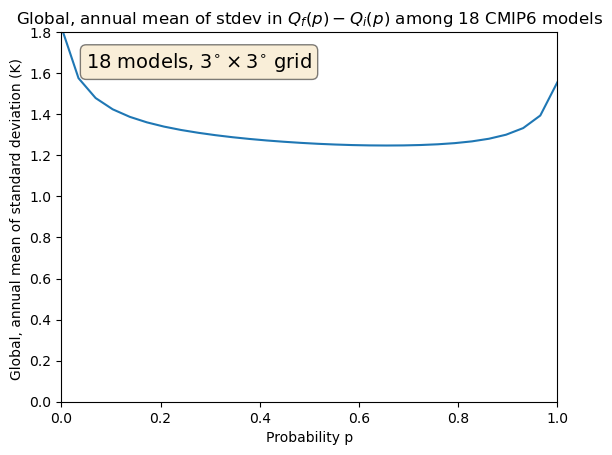

In [57]:
qano_std_agmean.plot()
plt.xlabel('Probability p')
plt.ylabel('Global, annual mean of standard deviation (K) ')
plt.title(r'Global, annual mean of stdev in $Q_f(p) -Q_i(p)$ among 18 CMIP6 models')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, r'18 models, $3^{\circ} \times 3^{\circ}$ grid', transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.ylim(0,1.8)
plt.xlim(0,1.0)

In [ ]:
#################################### Land and Ocean-only curves ########################

In [ ]:
################# Extra #################

In [ ]:
# #Iterate Over dsets_ Dictionary:
# for k, v in tqdm(dsets_.items()):
#     expt_dsets = v.values()
    
#     if any([d is None for d in expt_dsets]):
#         print(f"Missing experiment for {k}")
#         continue
    
#     dsets = [v[expt].pipe(process_data)
                             
#                       for expt in expts]
    
    
#     # Check if any of the experiment datasets is empty and skip this model if so
#     # print('k,v=',k,dsets)
#     # print('-------')
#     if any([ds is None for ds in dsets]):
#         print(f"Skipping {k} because one of the experiment datasets is empty")
#         continue
        
#     # align everything along model dim
#     dsets_aligned[k] = xr.concat(dsets, join='outer',
#                                  dim=expt_da)
#     print(dsets_aligned[k])
#     print('-----------------')

In [ ]:
# def remove_feb29(ds):
#     """
#     Remove February 29th for leap years and adjust day indices.
    
#     Parameters:
#     - ds (xarray.Dataset): Input dataset

#     Returns:
#     - xarray.Dataset: Modified dataset without February 29th for leap years.
#     """
    
#     # Check if the dataset has 366 days
#     if ds.dims['dayofyear'] == 366:
#         # Identify leap years
#         leap_years = [year for year in ds['year'].values if is_leap(year)]
        
        
#          # Create a mask to identify February 29 in leap years
#         mask_feb29 = (ds['dayofyear'] == 60) & ds['year'].isin(leap_years)
        
#         # Drop the values for February 29 in leap years
#         ds = ds.where(~mask_feb29, drop=True)
        
#         # Now, adjust the day indices for days after Feb 29 in leap years
        
#         mask_postfeb29 = (ds['dayofyear'] > 60) & ds['year'].isin(leap_years)
#         ds['dayofyear'].values[mask_postfeb29] -= 1
        
#         # if ds.dims['dayofyear'] == 366:
#         #     print(ds.sel(dayofyear=366).sel(lat=chicago_lat,lon=chicago_lon,method='nearest').values)
        
# #         # Drop dayofyear=60 only for leap years
# #         ds = ds.where(~((ds['dayofyear'] == 60) & ds['year'].isin(leap_years)), drop=True)
        
# #         # Adjust dayofyear indices for days after February 29th only for leap years
# #         dayofyear = ds['dayofyear'].values
# #         mask = (dayofyear > 60) & np.isin(ds['year'].values, leap_years)
# #         dayofyear[mask] -= 1
# #       ds = ds.assign_coords(dayofyear=('dayofyear', dayofyear))

#     return ds



In [ ]:
# #Select data for specific location to plot
# df_loc = final_ds.to_dataframe().reset_index()
# df_eoc = final_ds.sel(experiment_id='ssp370').sel(year= slice(2071,2100)).to_dataframe().reset_index()
# df_pi  = final_ds.sel(experiment_id='historical').sel(year= slice(1850,1879)).to_dataframe().reset_index()
# df_loc

In [ ]:
# sns.relplot(data=df_loc,x="year", y="tasmax", hue='experiment_id',
#             kind="line", errorbar="sd", aspect=2);

In [ ]:
# quantiles = np.linspace(0,1.0,30)
# quantiles

In [ ]:
# df_eoc_quants                  = df_eoc.groupby('source_id')['tasmax'].quantile(quantiles).reset_index()
# df_eoc_quants.columns          = ['source_id','quantiles','tasmax']
# df_eoc_quants['experiment_id'] = 'ssp370'
# df_eoc_quants

In [ ]:
# df_pi_quants                  = df_pi.groupby('source_id')['tasmax'].quantile(quantiles).reset_index()
# df_pi_quants.columns          = ['source_id','quantiles','tasmax']
# df_pi_quants['experiment_id'] = 'historical'
# df_pi_quants

In [ ]:
# df_quants = pd.concat([df_eoc_quants, df_pi_quants],ignore_index=True)
# df_quants 

In [ ]:
# g = sns.relplot(data=df_eoc_quants,x="quantiles", y="tasmax",hue='experiment_id',
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, EOC tasmax at Chicago: 21 CMIP6 models')

In [ ]:
# g = sns.relplot(data=df_quants,x="quantiles", y="tasmax",hue='experiment_id',
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, tasmax at Chicago: 21 CMIP6 models')

In [ ]:
############## Anomalies ###########################

In [ ]:
# # Pivot the table based on experiment_id
# df_pivot = df_quants.pivot_table(index=['source_id', 'quantiles'], columns='experiment_id', values='tasmax')
# df_pivot

In [ ]:
# # Calculate the difference
# df_pivot['tasmax_ano'] = df_pivot['ssp370'] - df_pivot['historical']
# df_pivot
# # Reset the index to turn multi-index back to columns
# df_quant_ano = df_pivot.reset_index()[['source_id', 'quantiles', 'tasmax_ano']]
# df_quant_ano

In [ ]:
# g = sns.relplot(data=df_quant_ano,x="quantiles", y="tasmax_ano",
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, tasmax anomaly at Chicago: 21 CMIP6 models')

In [ ]:
# # Group by quantiles and compute the standard deviation for Tasmax
# df_quantano_std = df_quant_ano.groupby('quantiles')['tasmax_ano'].std().reset_index()

# # Rename the column for clarity
# df_quantano_std.rename(columns={'tasmax_ano': 'tasmax_sdev'}, inplace=True)
# df_quantano_std

In [ ]:
# g = sns.relplot(data=df_quantano_std,x="quantiles", y="tasmax_sdev",
#             kind="line", errorbar="sd", aspect=2);
# g.fig.suptitle('son 30, tasmax std at Chicago: 21 CMIP6 models')